In [1]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# 可选：在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"


In [2]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, system_message: str):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符
        ]
    )
    
    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)



### 2. 定义工具

接下来我们定义一些未来智能体将使用的工具。

#### 注释说明：
- `tavily_tool`: 定义了一个 Tavily 搜索工具，可以搜索最多 5 条结果。
- `repl`: 定义了一个 Python REPL 工具，用于执行 Python 代码块。
- `python_repl` 函数：这是一个装饰的工具函数，接受 Python 代码作为输入，并通过 `PythonREPL` 环境执行代码。成功执行后返回执行的代码和输出。如果发生错误，则捕获并返回错误信息。


In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 搜索工具，用于搜索最多 5 条结果
tavily_tool = TavilySearchResults(max_results=5)

# Python REPL 工具，用于执行 Python 代码
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

-----------

### 3. 辅助函数：智能体节点

下面我们定义智能体节点函数（`agent_node`)，然后使用它分别定义2个智能体节点：
- Researcher
- Chart_Generator

#### 注释说明：

- `agent_node` 函数是一个辅助函数，用于创建一个智能体节点。它接受当前的 `state`（状态）、`agent`（智能体） 和 `name`（智能体的名称），并返回一个新的状态字典，包含消息和发送者。
- `research_agent`: 使用 `create_agent` 函数创建了一个研究智能体，使用 `research_llm` 作为语言模型，并且绑定了 `tavily_tool` 搜索工具。
- `chart_agent`: 同样使用 `create_agent` 创建了图表生成器智能体，使用 `chart_llm` 作为语言模型，并绑定了 `python_repl` 代码执行工具。
- `functools.partial`: 用于创建特定名称的智能体节点，例如 `"Researcher"` 和 `"Chart_Generator"`，并与各自的智能体绑定。

In [4]:
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

# 辅助函数：为智能体创建一个节点
def agent_node(state, agent, name):
    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        print(f"ToolMessage: {result}")
        
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并排除部分字段
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        # 我们使用严格的工作流程，通过记录发送者来知道接下来传递给谁
        "sender": name,
    }

#### 关于 `AIMessage` 构造

`AIMessage` 是 LangChain 中用于表示 AI 模型回复的类，它封装了 AI 生成的文本或内容。为了让 Python 初学者更好地理解，我们可以从以下几个方面详细说明 `AIMessage` 的构造方法及其相关概念。

##### `AIMessage` 构造方法简介

在代码中，`AIMessage(**result.dict(exclude={"type", "name"}), name=name)` 这段代码使用了 `AIMessage` 的构造方法。`AIMessage` 的目的是将 AI 生成的消息封装起来，方便后续处理和传递。这里的构造方法通过传递字典参数创建 `AIMessage` 对象。

##### `AIMessage` 类的常见构造参数：
- **content**: 这是消息的主要部分，通常是 AI 模型生成的文本内容。例如，一个简单的对话模型可能会生成一个包含回答问题的字符串。
- **name**: 可选参数，用于标识发送消息的 AI 模型或智能体的名称。在你的代码中，`name=name` 表示为智能体分配一个名称（如 `"Researcher"` 或 `"Chart_Generator"`），以便在不同智能体之间进行区分。
- **additional_metadata**: 有时候，消息不仅仅包含文本内容，还可能附加其他元数据，如调用的工具、时间戳等。

##### 深入理解构造方法中的步骤：

1. **`result.dict()`**: 
   这一部分将 `result` 对象转换为字典。字典是一种键值对的结构，便于存储和管理数据。Python 中的 `dict()` 方法会把 `result` 对象的所有属性转换成字典的形式，方便在构造 `AIMessage` 时传递这些数据。

2. **`exclude={"type", "name"}`**:
   在构造 `AIMessage` 时，使用了 `exclude` 参数来排除某些不必要的字段。`type` 和 `name` 这两个字段不会被传递给 `AIMessage`，这是因为它们可能不是 AI 消息本身的必要部分或已经在其他地方定义过。

3. **`name=name`**:
   这里的 `name` 参数表示智能体的名称，它是在 `agent_node` 函数中作为参数传递的。在构造 `AIMessage` 时，通过这个参数来标识消息的来源智能体是谁，比如 `"Researcher"` 或 `"Chart_Generator"`。

--------------

### 4. 定义 研究智能体及其节点


In [5]:
# 为 Agent 配置各自的大模型
research_llm = ChatOpenAI(model="gpt-4o", temperature=0.5)
chart_llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [6]:
# 研究智能体及其节点
research_agent = create_agent(
    research_llm,  # 使用 research_llm 作为研究智能体的语言模型
    [tavily_tool],  # 研究智能体使用 Tavily 搜索工具
    system_message="using the search engine,Only gathered the relevant data,do not create table or give final conclusions, leave that for other assistants.",  # 系统消息，指导智能体如何使用搜索工具
)

In [7]:
# 使用 functools.partial 创建研究智能体的节点，指定该节点的名称为 "Researcher"
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

### 5. 定义 表格生成器智能体及其节点

In [8]:
chart_agent = create_agent(
    chart_llm,  # 使用 chart_llm 作为图表生成器智能体的语言模型
    [],  # 图表生成器智能体使用 Python REPL 工具
    system_message="Create table based on the provided data.If you have completed all tasks, respond with FINAL ANSWER.",  # 系统消息，指导智能体如何生成图表
)

In [9]:
# 使用 functools.partial 创建图表生成器智能体的节点，指定该节点的名称为 "Chart_Generator"
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_Generator")

In [10]:
from langgraph.prebuilt import ToolNode

# 定义工具列表，包括 Tavily 搜索工具和 Python REPL 工具
tools = [tavily_tool, python_repl]

# 创建工具节点，负责工具的调用
tool_node = ToolNode(tools)

------------------------


### 7. 建立智能体节点间通信 AgentState

定义智能体节点和工具节点后，接下来需要在 Graph 中使它们互相通信。

因此，我们需要定义节点间的消息传递数据结构：AgentState

我们使用一个消息列表，并包含一个键来跟踪最近的发送者。

#### 注释说明：
- `AgentState` 是一个 `TypedDict`，它定义了图中传递的状态对象，包括 `messages` 和 `sender`。`messages` 用于存储传递的消息，`sender` 用于跟踪消息的发送者。


In [11]:
import operator
from typing import Annotated, Sequence, TypedDict

# 定义图中传递的对象，包含消息和发送者信息
class AgentState(TypedDict):
    # messages 是传递的消息，使用 Annotated 和 Sequence 来标记类型
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # sender 是发送消息的智能体
    sender: str


### 8. 定义工作流（状态图）

我们现在将所有内容组合在一起，定义多智能体的完整状态图。

#### 注释说明：

- `StateGraph(AgentState)`：用于创建一个状态图 `workflow`，其状态由 `AgentState` 管理。
- `add_node`：将智能体节点 `Researcher`、`Chart_Generator` 和 `call_tool` 添加到状态图中，每个节点对应一个任务或功能。
- `add_conditional_edges`：为节点添加条件边，基于 `router` 函数的返回值来决定下一个要执行的步骤。
  - `continue`：继续到另一个智能体节点。
  - `call_tool`：调用工具节点。
  - `__end__`：结束流程。
- `add_edge`：将开始节点 `START` 与初始节点 `Researcher` 连接，定义工作流的启动顺序。
- `compile`：编译状态图，准备好执行任务。

#### Graph 对象关键方法 API

- **add_conditional_edges**: https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+conditional+edges#stategraph
- **get_graph**: https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+conditional+edges#langgraph.graph.graph.CompiledGraph.get_graph


In [12]:
# 创建一个状态图 workflow，使用 AgentState 来管理状态
workflow = StateGraph(AgentState)

# 将研究智能体节点、图表生成器智能体节点和工具节点添加到状态图中
workflow.add_node("Researcher", research_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("call_tool", tool_node)


#### 定义路由函数

接下来定义边逻辑，以根据智能体的结果来决定下一步操作。

#### 注释说明：
- `router` 函数是工作流中的一个关键逻辑，用于根据当前的状态和消息内容来决定下一步的操作。
- 如果最新的消息中包含工具调用（`tool_calls`），则返回 `"call_tool"`，表示需要调用工具。
- 如果消息内容中包含 `"FINAL ANSWER"`，表示任务已经完成，返回 `"__end__"` 来结束任务。
- 如果没有满足以上条件，则返回 `"continue"`，表示继续任务并执行下一步操作。

In [13]:
from typing import Literal

# 路由器函数，用于决定下一步是执行工具还是结束任务
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]  # 获取当前状态中的消息列表
    last_message = messages[-1]  # 获取最新的一条消息
    
    # 如果最新消息包含工具调用，则返回 "call_tool"，指示执行工具
    if last_message.tool_calls:
        return "call_tool"
    
    # 如果最新消息中包含 "FINAL ANSWER"，表示任务已完成，返回 "__end__" 结束工作流
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    # 如果既没有工具调用也没有完成任务，继续流程，返回 "continue"
    return "continue"


#### 定义条件边逻辑

In [14]:
# 为 "Researcher" 智能体节点添加条件边，根据 router 函数的返回值进行分支
workflow.add_conditional_edges(
    "Researcher",
    router,  # 路由器函数决定下一步
    {
        "continue": "Chart_Generator",  # 如果 router 返回 "continue"，则传递到 Chart_Generator
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "Chart_Generator" 智能体节点添加条件边
workflow.add_conditional_edges(
    "Chart_Generator",
    router,  # 同样使用 router 函数决定下一步
    {
        "continue": "Researcher",  # 如果 router 返回 "continue"，则回到 Researcher
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "call_tool" 工具节点添加条件边，基于“sender”字段决定下一个节点
# 工具调用节点不更新 sender 字段，这意味着边将返回给调用工具的智能体
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],  # 根据 sender 字段判断调用工具的是哪个智能体
    {
        "Researcher": "Researcher",  # 如果 sender 是 Researcher，则返回给 Researcher
        "Chart_Generator": "Chart_Generator",  # 如果 sender 是 Chart_Generator，则返回给 Chart_Generator
    },
)


In [15]:
# 添加开始节点，将流程从 START 节点连接到 Researcher 节点
workflow.add_edge(START, "Researcher")

# 编译状态图以便后续使用
graph = workflow.compile()

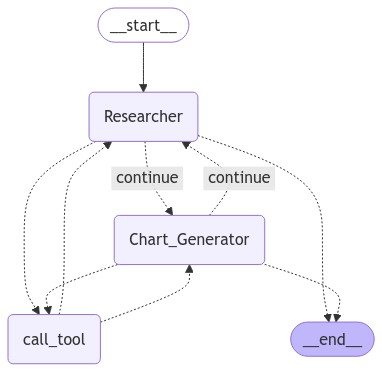

In [16]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")


### 9. 执行工作流

接下来我们将执行多智能体构建的工作流，最终生成一些统计图表。

In [17]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="first Obtain the GDP of the United States from 2000 to 2020, "
            "second make a table based on the data. End the task after generating the table."
            )
        ],
    },
    # 设置最大递归限制
    {"recursion_limit": 20},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  # 打印消息内容


================================ Human Message =================================

first Obtain the GDP of the United States from 2000 to 2020, second make a table based on the data. End the task after generating the table.
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_CWzJZnYlRcQxM4GdF22Zvbbc)
 Call ID: call_CWzJZnYlRcQxM4GdF22Zvbbc
  Args:
    query: US GDP from 2000 to 2020
  tavily_search_results_json (call_4ZyylfJhkENwPBpC1e6K82E2)
 Call ID: call_4ZyylfJhkENwPBpC1e6K82E2
  Args:
    query: United States historical GDP data 2000-2020
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://ycharts.com/indicators/us_gdp", "content": "Stats\nHistorical Data\nBasic Info\nUS GDP is at a current level of 27.61T, up from 27.06T last quarter and up from 25.99T one year ago.\n Level Chart\nBasic Info\nUS GDP is at a cu

## Homework

1. 使用不同的大模型运行多智能体，对比结果并评选 `gpt-4o` 之下最好的大模型，将所有的大模型和最终结果生成一张表格；
2. 将 `Chart_Generator` 替换为其他功能智能体（如 `table_generator`），为其设计提示词，然后运行查看生成结果。
3. [**可选**]优化研究智能体 `Researcher` 提示词和路由函数 `route` 跳转逻辑，提升图表生成的成功率。